<a href="https://colab.research.google.com/github/VivekKejriwal/TheSchoolOfAI/blob/main/Assignment_6/Submission_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install torch
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

In [2]:
#REQUIRED TRANSFORMS CREATED

train_transforms = transforms.Compose([
    transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
    transforms.ToTensor(),
    transforms.Normalize((.1307,),(0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.1307,),(0.3081,))
])

In [3]:
#LOADING REQUIRED MNIST DATA

train = datasets.MNIST('./data',download=True,train=True,transform= train_transforms)
test  = datasets.MNIST('./data',download=True,train=False,transform= test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 1

#CUDA?
cuda = torch.cuda.is_available()
#print(cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size = 128, num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#train loader

train_loader = torch.utils.data.DataLoader(train,**dataloader_args)

#test loader

test_loader = torch.utils.data.DataLoader(test,**dataloader_args)

In [5]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(1,8,3,padding=1), #INPUT- 28X28X1 OUTPUT- 28X28X8 RF- 3
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,8,3,padding=1), #INPUT- 28X28X8 OUTPUT- 28X28X8 RF- 5
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.MaxPool2d(2,2) #RF- 6
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(8,8,3,padding=0), #INPUT- 14X14X8 OUTPUT- 12X12X8 RF- 10
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,8,3,padding=0), #INPUT- 12X12X8 OUTPUT- 10X10X8 RF-14
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,8,3,padding=0), #INPUT- 10X10X8 OUTPUT- 8X8X8 RF- 18
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,16,3,padding=0), #INPUT- 8X8X8 OUTPUT- 6X6X16 RF- 22
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(0.01)
        
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(16,32,3), #INPUT- 6X6X16 OUTPUT- 4X4X32 RF-24
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout(0.01),
        
        nn.AvgPool2d(4), #INPUT- 4X4X32 OUTPUT- 1X1X32 RF-40
        
        nn.Conv2d(32,10,1) #INPUT- 1X1X32 OUTPUT- 1X1X10
        
    )

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(-1,10)
    return F.log_softmax(x, dim=1)


In [6]:
#!pip install torchsummary

from torchsummary import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)

model = Net().to(device)
summary(model, input_size = (1, 28, 28))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             584
       BatchNorm2d-6            [-1, 8, 28, 28]              16
              ReLU-7            [-1, 8, 28, 28]               0
           Dropout-8            [-1, 8, 28, 28]               0
         MaxPool2d-9            [-1, 8, 14, 14]               0
           Conv2d-10            [-1, 8, 12, 12]             584
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14            [-

In [7]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=False):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

In [8]:
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [9]:
class NetWithGBN(nn.Module):
  def __init__(self):
    super(NetWithGBN,self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(1,8,3,padding=1), #INPUT- 28X28X1 OUTPUT- 28X28X8 RF- 3
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,8,3,padding=1), #INPUT- 28X28X8 OUTPUT- 28X28X8 RF- 5
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.MaxPool2d(2,2) #RF- 6
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(8,8,3,padding=0), #INPUT- 14X14X8 OUTPUT- 12X12X8 RF- 10
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,8,3,padding=0), #INPUT- 12X12X8 OUTPUT- 10X10X8 RF-14
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,8,3,padding=0), #INPUT- 10X10X8 OUTPUT- 8X8X8 RF- 18
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,16,3,padding=0), #INPUT- 8X8X8 OUTPUT- 6X6X16 RF- 22
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(0.01)
        
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(16,32,3), #INPUT- 6X6X16 OUTPUT- 4X4X32 RF-26
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout(0.01),
        
        nn.AvgPool2d(4), #INPUT- 4X4X32 OUTPUT- 1X1X32 RF-32
        
        nn.Conv2d(32,10,1) #INPUT- 1X1X32 OUTPUT- 1X1X10 RF-32
        
    )

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(-1,10)
    return F.log_softmax(x, dim=1)


In [10]:
from torchsummary import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)

model = NetWithGBN().to(device)
summary(model, input_size = (1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             584
       BatchNorm2d-6            [-1, 8, 28, 28]              16
              ReLU-7            [-1, 8, 28, 28]               0
           Dropout-8            [-1, 8, 28, 28]               0
         MaxPool2d-9            [-1, 8, 14, 14]               0
           Conv2d-10            [-1, 8, 12, 12]             584
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14            [-

In [11]:
from tqdm import tqdm
class Trainer():
  def __init__(self):
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []

  def train(self,model,device,train_loader,optimizer,epoch,lambda_l1):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    
    for batch_id,(data, target) in enumerate(pbar):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()

      y_pred = model(data)

      loss= F.nll_loss(y_pred,target)

      l1=0
      for param in model.parameters():
        l1+= param.abs().sum()
      loss+= lambda_l1*l1

      self.train_losses.append(loss)
      
      loss.backward()
      optimizer.step()

      pred = y_pred.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed+= len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_size={batch_id} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)

  def test(self,model,device,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss = F.nll_loss(output, target, reduction='sum').item()
        pred = output.argmax(dim= 1,keepdim=True)
        correct+= pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    self.test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Acccuracy= {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100.*correct/len(test_loader.dataset)))
    
    self.test_acc.append(100.*correct/len(test_loader.dataset))
  
  def getValues(self):
    return (self.train_losses,self.test_losses,self.train_acc,self.test_acc)

  def get_misclassified(self, model, test_loader, device):
    misclassified = []
    misclassified_pred= []
    misclassified_target= []

    model.eval()

    with torch.no_grad():
      for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        list_misclassified = (pred.eq(target.view_as(pred))== False)
        batch_misclassified = data[list_misclassified]
        batch_mis_pred = pred[list_misclassified]
        batch_mis_target = target.view_as(pred)[list_misclassified]

        misclassified.append(batch_misclassified)
        misclassified_pred.append(batch_mis_pred)
        misclassified_target.append(batch_mis_target)

    misclassified = torch.cat(misclassified)
    misclassified_pred = torch.cat(misclassified_pred)
    misclassified_target = torch.cat(misclassified_target)

    return list(map(lambda x,y,z: (x,y,z) ,misclassified, misclassified_pred, misclassified_target))



In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_acc, test_losses, test_acc):
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")

def plot_misclassification(misclassified):
    print('Total Misclassifications : {}'.format(len(misclassified)))
    num_images = 25
    fig = plt.figure(figsize=(14, 16))
    fig.suptitle('Misclassifications')
    for idx, (image, pred, target) in enumerate(misclassified[:num_images]):
        image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
        ax = fig.add_subplot(5, 5, idx+1)
        ax.axis('off')
        ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
        ax.imshow(image.squeeze())
    plt.show()

In [13]:
from torch.optim.lr_scheduler import StepLR

model_gbn = NetWithGBN().to(device)
model_bn = Net().to(device)


  

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]


-----------------------------------------------

-----------------------------------------------
BN_L1
EPOCH: 0 last LR= [0.01] LR =  [0.01]


Loss=0.13257144391536713 Batch_size=468 Accuracy=87.56: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Acccuracy= 9825/10000 (98.25%)

EPOCH: 1 last LR= [0.01] LR =  [0.01]


Loss=0.06796848028898239 Batch_size=468 Accuracy=97.47: 100%|██████████| 469/469 [00:19<00:00, 24.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9849/10000 (98.49%)

EPOCH: 2 last LR= [0.01] LR =  [0.01]


Loss=0.09805860370397568 Batch_size=468 Accuracy=97.87: 100%|██████████| 469/469 [00:19<00:00, 24.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9873/10000 (98.73%)

EPOCH: 3 last LR= [0.01] LR =  [0.01]


Loss=0.06013994291424751 Batch_size=468 Accuracy=98.07: 100%|██████████| 469/469 [00:19<00:00, 24.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9843/10000 (98.43%)

EPOCH: 4 last LR= [0.01] LR =  [0.01]


Loss=0.08023721724748611 Batch_size=468 Accuracy=98.14: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9852/10000 (98.52%)

EPOCH: 5 last LR= [0.01] LR =  [0.01]


Loss=0.1586580127477646 Batch_size=468 Accuracy=98.12: 100%|██████████| 469/469 [00:18<00:00, 25.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9846/10000 (98.46%)

EPOCH: 6 last LR= [0.001] LR =  [0.0001]


Loss=0.09256285429000854 Batch_size=468 Accuracy=98.72: 100%|██████████| 469/469 [00:18<00:00, 25.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9924/10000 (99.24%)

EPOCH: 7 last LR= [0.001] LR =  [0.001]


Loss=0.09538879990577698 Batch_size=468 Accuracy=98.76: 100%|██████████| 469/469 [00:18<00:00, 25.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9926/10000 (99.26%)

EPOCH: 8 last LR= [0.001] LR =  [0.001]


Loss=0.06253230571746826 Batch_size=468 Accuracy=98.87: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9928/10000 (99.28%)

EPOCH: 9 last LR= [0.001] LR =  [0.001]


Loss=0.08995617181062698 Batch_size=468 Accuracy=98.82: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9929/10000 (99.29%)

EPOCH: 10 last LR= [0.001] LR =  [0.001]


Loss=0.07734779268503189 Batch_size=468 Accuracy=98.82: 100%|██████████| 469/469 [00:18<00:00, 25.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9935/10000 (99.35%)

EPOCH: 11 last LR= [0.001] LR =  [0.001]


Loss=0.04333120584487915 Batch_size=468 Accuracy=98.82: 100%|██████████| 469/469 [00:18<00:00, 24.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9938/10000 (99.38%)

EPOCH: 12 last LR= [0.0001] LR =  [1e-05]


Loss=0.11592662334442139 Batch_size=468 Accuracy=98.93: 100%|██████████| 469/469 [00:18<00:00, 25.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9940/10000 (99.40%)

EPOCH: 13 last LR= [0.0001] LR =  [0.0001]


Loss=0.04983179271221161 Batch_size=468 Accuracy=98.97: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9935/10000 (99.35%)

EPOCH: 14 last LR= [0.0001] LR =  [0.0001]


Loss=0.03330579027533531 Batch_size=468 Accuracy=98.90: 100%|██████████| 469/469 [00:18<00:00, 25.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9936/10000 (99.36%)

EPOCH: 15 last LR= [0.0001] LR =  [0.0001]


Loss=0.0716867670416832 Batch_size=468 Accuracy=98.98: 100%|██████████| 469/469 [00:18<00:00, 26.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9937/10000 (99.37%)

EPOCH: 16 last LR= [0.0001] LR =  [0.0001]


Loss=0.05101874843239784 Batch_size=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 26.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9934/10000 (99.34%)

EPOCH: 17 last LR= [0.0001] LR =  [0.0001]


Loss=0.07393825799226761 Batch_size=468 Accuracy=98.96: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9937/10000 (99.37%)

EPOCH: 18 last LR= [1e-05] LR =  [1.0000000000000002e-06]


Loss=0.07679959386587143 Batch_size=468 Accuracy=98.97: 100%|██████████| 469/469 [00:18<00:00, 25.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9937/10000 (99.37%)

EPOCH: 19 last LR= [1e-05] LR =  [1e-05]


Loss=0.050517719238996506 Batch_size=468 Accuracy=98.95: 100%|██████████| 469/469 [00:18<00:00, 25.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9935/10000 (99.35%)

EPOCH: 20 last LR= [1e-05] LR =  [1e-05]


Loss=0.04947662726044655 Batch_size=468 Accuracy=98.92: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9933/10000 (99.33%)

EPOCH: 21 last LR= [1e-05] LR =  [1e-05]


Loss=0.04158604517579079 Batch_size=468 Accuracy=99.01: 100%|██████████| 469/469 [00:18<00:00, 25.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Acccuracy= 9939/10000 (99.39%)

EPOCH: 22 last LR= [1e-05] LR =  [1e-05]


Loss=0.03807377442717552 Batch_size=468 Accuracy=98.93: 100%|██████████| 469/469 [00:18<00:00, 25.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9937/10000 (99.37%)

EPOCH: 23 last LR= [1e-05] LR =  [1e-05]


Loss=0.064098060131073 Batch_size=468 Accuracy=99.02: 100%|██████████| 469/469 [00:19<00:00, 24.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9936/10000 (99.36%)

EPOCH: 24 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-07]


Loss=0.049758974462747574 Batch_size=468 Accuracy=98.97: 100%|██████████| 469/469 [00:18<00:00, 25.32it/s]



Test set: Average loss: 0.0000, Acccuracy= 9938/10000 (99.38%)

Total Misclassifications : 62


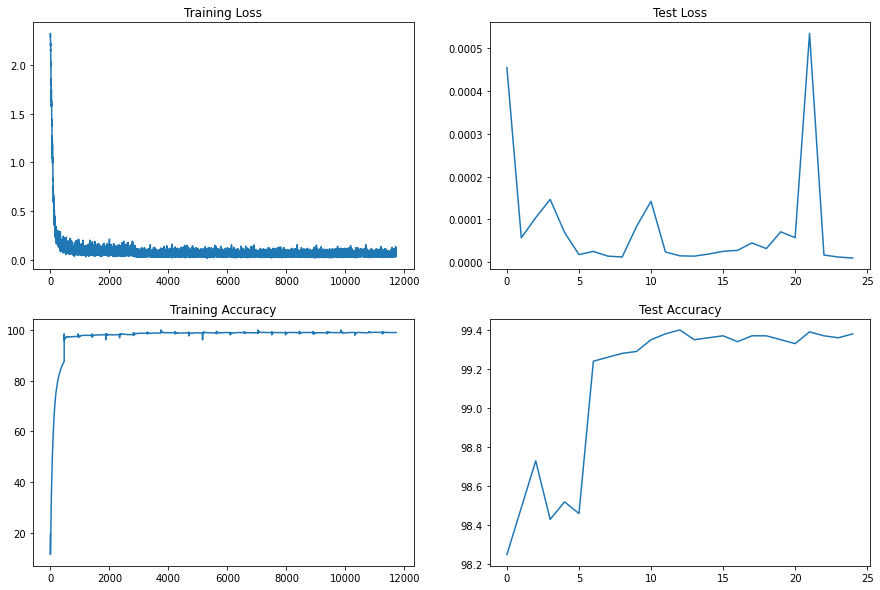

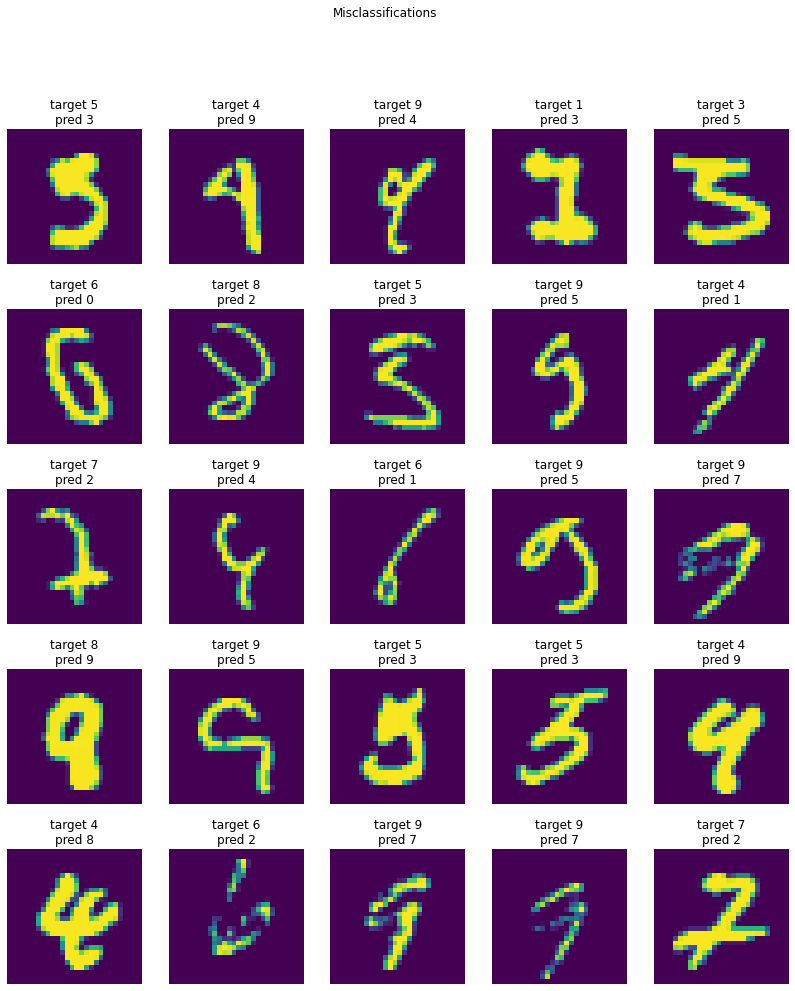

  0%|          | 0/469 [00:00<?, ?it/s]


-----------------------------------------------

-----------------------------------------------
BN_L2
EPOCH: 0 last LR= [0.01] LR =  [0.01]


Loss=0.4329516887664795 Batch_size=468 Accuracy=87.54: 100%|██████████| 469/469 [00:18<00:00, 25.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9790/10000 (97.90%)

EPOCH: 1 last LR= [0.01] LR =  [0.01]


Loss=0.2317357063293457 Batch_size=468 Accuracy=97.61: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Acccuracy= 9781/10000 (97.81%)

EPOCH: 2 last LR= [0.01] LR =  [0.01]


Loss=0.26896193623542786 Batch_size=468 Accuracy=97.77: 100%|██████████| 469/469 [00:17<00:00, 26.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9845/10000 (98.45%)

EPOCH: 3 last LR= [0.01] LR =  [0.01]


Loss=0.23639020323753357 Batch_size=468 Accuracy=97.83: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9819/10000 (98.19%)

EPOCH: 4 last LR= [0.01] LR =  [0.01]


Loss=0.24511995911598206 Batch_size=468 Accuracy=97.94: 100%|██████████| 469/469 [00:18<00:00, 25.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9885/10000 (98.85%)

EPOCH: 5 last LR= [0.01] LR =  [0.01]


Loss=0.2712986171245575 Batch_size=468 Accuracy=98.02: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9882/10000 (98.82%)

EPOCH: 6 last LR= [0.001] LR =  [0.0001]


Loss=0.1990612894296646 Batch_size=468 Accuracy=98.72: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9929/10000 (99.29%)

EPOCH: 7 last LR= [0.001] LR =  [0.001]


Loss=0.22870397567749023 Batch_size=468 Accuracy=98.86: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9939/10000 (99.39%)

EPOCH: 8 last LR= [0.001] LR =  [0.001]


Loss=0.17227105796337128 Batch_size=468 Accuracy=98.79: 100%|██████████| 469/469 [00:17<00:00, 26.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9942/10000 (99.42%)

EPOCH: 9 last LR= [0.001] LR =  [0.001]


Loss=0.1766047328710556 Batch_size=468 Accuracy=98.90: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Acccuracy= 9933/10000 (99.33%)

EPOCH: 10 last LR= [0.001] LR =  [0.001]


Loss=0.18628564476966858 Batch_size=468 Accuracy=98.90: 100%|██████████| 469/469 [00:18<00:00, 25.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Acccuracy= 9942/10000 (99.42%)

EPOCH: 11 last LR= [0.001] LR =  [0.001]


Loss=0.20184829831123352 Batch_size=468 Accuracy=98.88: 100%|██████████| 469/469 [00:18<00:00, 25.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9943/10000 (99.43%)

EPOCH: 12 last LR= [0.0001] LR =  [1e-05]


Loss=0.1843479722738266 Batch_size=468 Accuracy=98.98: 100%|██████████| 469/469 [00:18<00:00, 25.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9953/10000 (99.53%)

EPOCH: 13 last LR= [0.0001] LR =  [0.0001]


Loss=0.1598617285490036 Batch_size=468 Accuracy=99.10: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9944/10000 (99.44%)

EPOCH: 14 last LR= [0.0001] LR =  [0.0001]


Loss=0.1999974399805069 Batch_size=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9946/10000 (99.46%)

EPOCH: 15 last LR= [0.0001] LR =  [0.0001]


Loss=0.15129433572292328 Batch_size=468 Accuracy=98.97: 100%|██████████| 469/469 [00:19<00:00, 24.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9946/10000 (99.46%)

EPOCH: 16 last LR= [0.0001] LR =  [0.0001]


Loss=0.14712968468666077 Batch_size=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9944/10000 (99.44%)

EPOCH: 17 last LR= [0.0001] LR =  [0.0001]


Loss=0.14538222551345825 Batch_size=468 Accuracy=99.02: 100%|██████████| 469/469 [00:19<00:00, 24.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9945/10000 (99.45%)

EPOCH: 18 last LR= [1e-05] LR =  [1.0000000000000002e-06]


Loss=0.1538681834936142 Batch_size=468 Accuracy=99.05: 100%|██████████| 469/469 [00:18<00:00, 25.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9943/10000 (99.43%)

EPOCH: 19 last LR= [1e-05] LR =  [1e-05]


Loss=0.16003070771694183 Batch_size=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9948/10000 (99.48%)

EPOCH: 20 last LR= [1e-05] LR =  [1e-05]


Loss=0.15273934602737427 Batch_size=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 26.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9948/10000 (99.48%)

EPOCH: 21 last LR= [1e-05] LR =  [1e-05]


Loss=0.14987114071846008 Batch_size=468 Accuracy=99.02: 100%|██████████| 469/469 [00:18<00:00, 25.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9947/10000 (99.47%)

EPOCH: 22 last LR= [1e-05] LR =  [1e-05]


Loss=0.1548328399658203 Batch_size=468 Accuracy=99.07: 100%|██████████| 469/469 [00:18<00:00, 25.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9945/10000 (99.45%)

EPOCH: 23 last LR= [1e-05] LR =  [1e-05]


Loss=0.15113553404808044 Batch_size=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9944/10000 (99.44%)

EPOCH: 24 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-07]


Loss=0.18437515199184418 Batch_size=468 Accuracy=99.05: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]



Test set: Average loss: 0.0002, Acccuracy= 9949/10000 (99.49%)

Total Misclassifications : 51


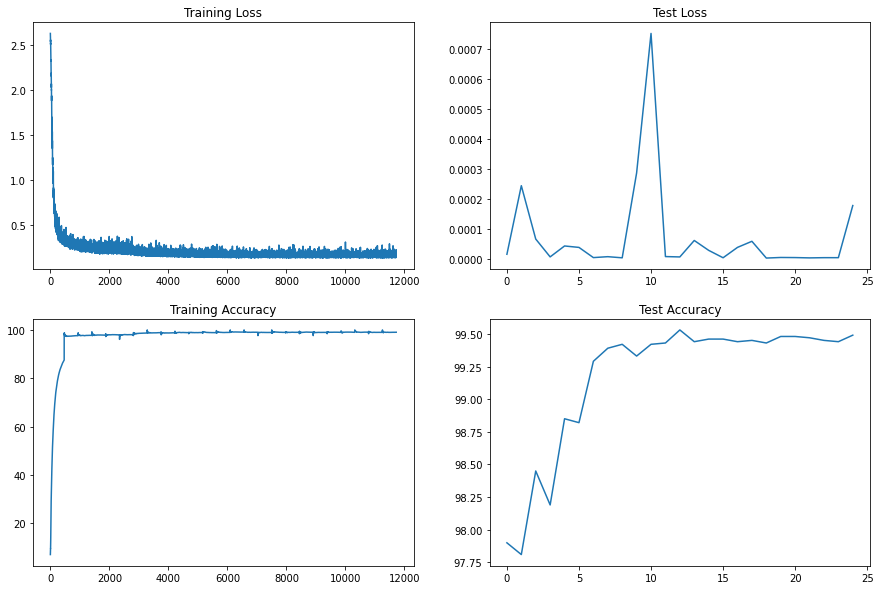

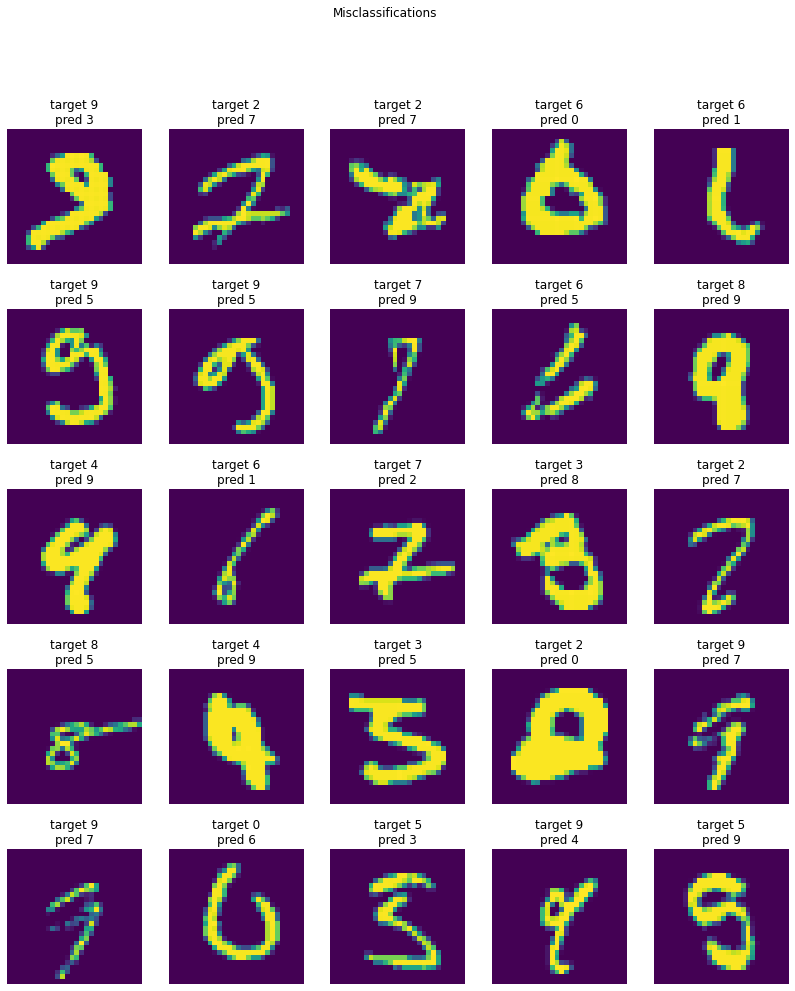

  0%|          | 0/469 [00:00<?, ?it/s]


-----------------------------------------------

-----------------------------------------------
bn_L1_L2
EPOCH: 0 last LR= [0.01] LR =  [0.01]


Loss=0.2915225028991699 Batch_size=468 Accuracy=86.97: 100%|██████████| 469/469 [00:18<00:00, 25.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Acccuracy= 9806/10000 (98.06%)

EPOCH: 1 last LR= [0.01] LR =  [0.01]


Loss=0.23648308217525482 Batch_size=468 Accuracy=97.31: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9731/10000 (97.31%)

EPOCH: 2 last LR= [0.01] LR =  [0.01]


Loss=0.28043174743652344 Batch_size=468 Accuracy=97.56: 100%|██████████| 469/469 [00:18<00:00, 24.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Acccuracy= 9792/10000 (97.92%)

EPOCH: 3 last LR= [0.01] LR =  [0.01]


Loss=0.25877195596694946 Batch_size=468 Accuracy=97.62: 100%|██████████| 469/469 [00:18<00:00, 24.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9808/10000 (98.08%)

EPOCH: 4 last LR= [0.01] LR =  [0.01]


Loss=0.29010963439941406 Batch_size=468 Accuracy=97.64: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9742/10000 (97.42%)

EPOCH: 5 last LR= [0.01] LR =  [0.01]


Loss=0.27118420600891113 Batch_size=468 Accuracy=97.68: 100%|██████████| 469/469 [00:18<00:00, 25.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Acccuracy= 9607/10000 (96.07%)

EPOCH: 6 last LR= [0.001] LR =  [0.0001]


Loss=0.20509019494056702 Batch_size=468 Accuracy=98.57: 100%|██████████| 469/469 [00:18<00:00, 25.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9919/10000 (99.19%)

EPOCH: 7 last LR= [0.001] LR =  [0.001]


Loss=0.153732031583786 Batch_size=468 Accuracy=98.62: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9927/10000 (99.27%)

EPOCH: 8 last LR= [0.001] LR =  [0.001]


Loss=0.19060301780700684 Batch_size=468 Accuracy=98.65: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9917/10000 (99.17%)

EPOCH: 9 last LR= [0.001] LR =  [0.001]


Loss=0.19253043830394745 Batch_size=468 Accuracy=98.64: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9908/10000 (99.08%)

EPOCH: 10 last LR= [0.001] LR =  [0.001]


Loss=0.17446550726890564 Batch_size=468 Accuracy=98.61: 100%|██████████| 469/469 [00:18<00:00, 25.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9920/10000 (99.20%)

EPOCH: 11 last LR= [0.001] LR =  [0.001]


Loss=0.1766127198934555 Batch_size=468 Accuracy=98.64: 100%|██████████| 469/469 [00:18<00:00, 26.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9926/10000 (99.26%)

EPOCH: 12 last LR= [0.0001] LR =  [1e-05]


Loss=0.13914620876312256 Batch_size=468 Accuracy=98.77: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9927/10000 (99.27%)

EPOCH: 13 last LR= [0.0001] LR =  [0.0001]


Loss=0.1261393427848816 Batch_size=468 Accuracy=98.86: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9927/10000 (99.27%)

EPOCH: 14 last LR= [0.0001] LR =  [0.0001]


Loss=0.144100159406662 Batch_size=468 Accuracy=98.84: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Acccuracy= 9929/10000 (99.29%)

EPOCH: 15 last LR= [0.0001] LR =  [0.0001]


Loss=0.21249094605445862 Batch_size=468 Accuracy=98.81: 100%|██████████| 469/469 [00:18<00:00, 25.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9925/10000 (99.25%)

EPOCH: 16 last LR= [0.0001] LR =  [0.0001]


Loss=0.16736751794815063 Batch_size=468 Accuracy=98.86: 100%|██████████| 469/469 [00:18<00:00, 25.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9929/10000 (99.29%)

EPOCH: 17 last LR= [0.0001] LR =  [0.0001]


Loss=0.18518200516700745 Batch_size=468 Accuracy=98.79: 100%|██████████| 469/469 [00:18<00:00, 25.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9929/10000 (99.29%)

EPOCH: 18 last LR= [1e-05] LR =  [1.0000000000000002e-06]


Loss=0.12121014297008514 Batch_size=468 Accuracy=98.85: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9928/10000 (99.28%)

EPOCH: 19 last LR= [1e-05] LR =  [1e-05]


Loss=0.1719965636730194 Batch_size=468 Accuracy=98.88: 100%|██████████| 469/469 [00:18<00:00, 25.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9928/10000 (99.28%)

EPOCH: 20 last LR= [1e-05] LR =  [1e-05]


Loss=0.13659939169883728 Batch_size=468 Accuracy=98.92: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9930/10000 (99.30%)

EPOCH: 21 last LR= [1e-05] LR =  [1e-05]


Loss=0.1319384127855301 Batch_size=468 Accuracy=98.89: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9928/10000 (99.28%)

EPOCH: 22 last LR= [1e-05] LR =  [1e-05]


Loss=0.17118018865585327 Batch_size=468 Accuracy=98.88: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9928/10000 (99.28%)

EPOCH: 23 last LR= [1e-05] LR =  [1e-05]


Loss=0.17385496199131012 Batch_size=468 Accuracy=98.85: 100%|██████████| 469/469 [00:18<00:00, 25.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9930/10000 (99.30%)

EPOCH: 24 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-07]


Loss=0.1841469258069992 Batch_size=468 Accuracy=98.86: 100%|██████████| 469/469 [00:18<00:00, 25.41it/s]



Test set: Average loss: 0.0000, Acccuracy= 9929/10000 (99.29%)

Total Misclassifications : 71


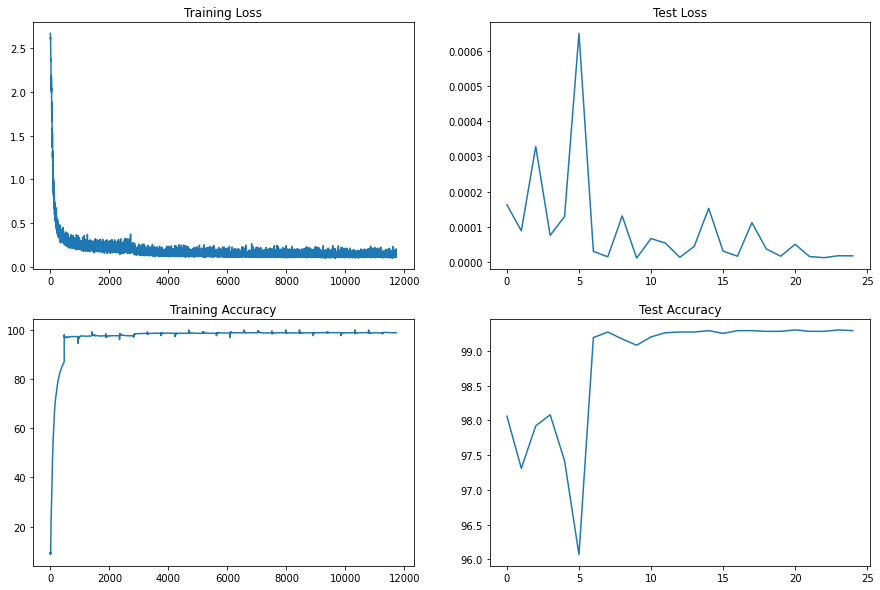

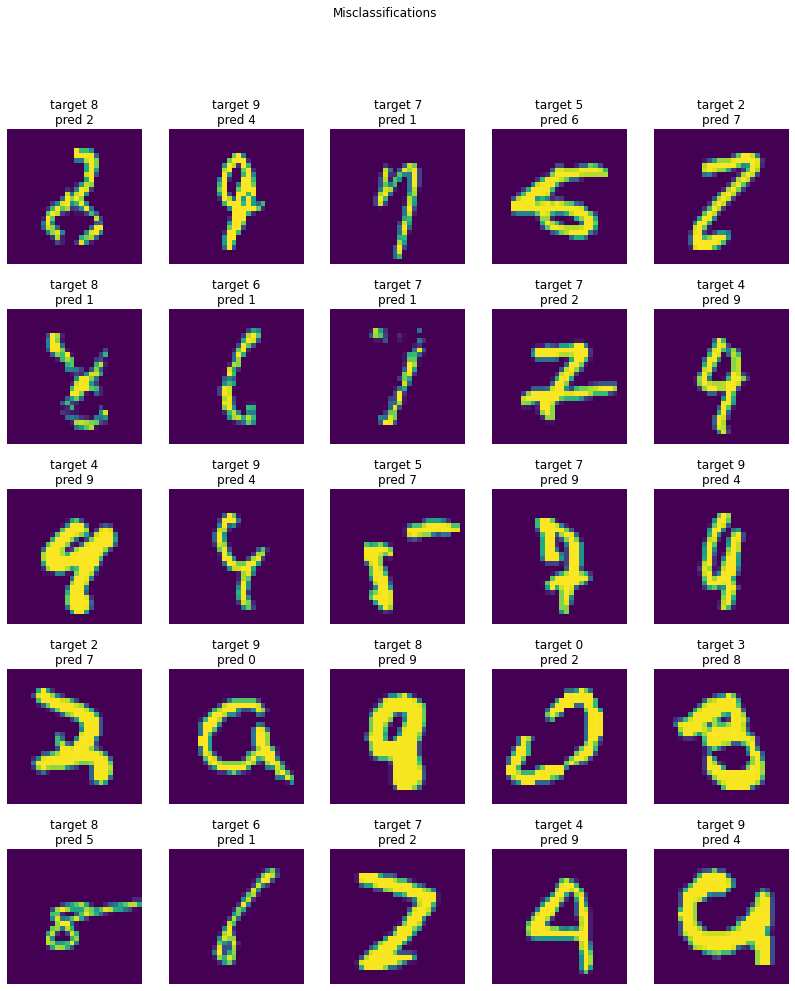

  0%|          | 0/469 [00:00<?, ?it/s]


-----------------------------------------------

-----------------------------------------------
GBN
EPOCH: 0 last LR= [0.01] LR =  [0.01]


Loss=0.11518380790948868 Batch_size=468 Accuracy=89.23: 100%|██████████| 469/469 [00:18<00:00, 25.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9773/10000 (97.73%)

EPOCH: 1 last LR= [0.01] LR =  [0.01]


Loss=0.046538855880498886 Batch_size=468 Accuracy=97.41: 100%|██████████| 469/469 [00:18<00:00, 25.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9822/10000 (98.22%)

EPOCH: 2 last LR= [0.01] LR =  [0.01]


Loss=0.036254849284887314 Batch_size=468 Accuracy=97.93: 100%|██████████| 469/469 [00:18<00:00, 24.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9871/10000 (98.71%)

EPOCH: 3 last LR= [0.01] LR =  [0.01]


Loss=0.060648515820503235 Batch_size=468 Accuracy=98.25: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9888/10000 (98.88%)

EPOCH: 4 last LR= [0.01] LR =  [0.01]


Loss=0.03076147846877575 Batch_size=468 Accuracy=98.47: 100%|██████████| 469/469 [00:18<00:00, 25.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9911/10000 (99.11%)

EPOCH: 5 last LR= [0.01] LR =  [0.01]


Loss=0.028516672551631927 Batch_size=468 Accuracy=98.48: 100%|██████████| 469/469 [00:17<00:00, 26.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9909/10000 (99.09%)

EPOCH: 6 last LR= [0.001] LR =  [0.0001]


Loss=0.008048702962696552 Batch_size=468 Accuracy=98.86: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9924/10000 (99.24%)

EPOCH: 7 last LR= [0.001] LR =  [0.001]


Loss=0.025073109194636345 Batch_size=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9929/10000 (99.29%)

EPOCH: 8 last LR= [0.001] LR =  [0.001]


Loss=0.05414094030857086 Batch_size=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9928/10000 (99.28%)

EPOCH: 9 last LR= [0.001] LR =  [0.001]


Loss=0.008033324033021927 Batch_size=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9930/10000 (99.30%)

EPOCH: 10 last LR= [0.001] LR =  [0.001]


Loss=0.048699866980314255 Batch_size=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9927/10000 (99.27%)

EPOCH: 11 last LR= [0.001] LR =  [0.001]


Loss=0.060620423406362534 Batch_size=468 Accuracy=98.99: 100%|██████████| 469/469 [00:18<00:00, 25.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9924/10000 (99.24%)

EPOCH: 12 last LR= [0.0001] LR =  [1e-05]


Loss=0.012383566237986088 Batch_size=468 Accuracy=99.00: 100%|██████████| 469/469 [00:18<00:00, 25.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9928/10000 (99.28%)

EPOCH: 13 last LR= [0.0001] LR =  [0.0001]


Loss=0.008206788450479507 Batch_size=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9928/10000 (99.28%)

EPOCH: 14 last LR= [0.0001] LR =  [0.0001]


Loss=0.028722291812300682 Batch_size=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9929/10000 (99.29%)

EPOCH: 15 last LR= [0.0001] LR =  [0.0001]


Loss=0.017694013193249702 Batch_size=468 Accuracy=99.02: 100%|██████████| 469/469 [00:18<00:00, 26.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9930/10000 (99.30%)

EPOCH: 16 last LR= [0.0001] LR =  [0.0001]


Loss=0.044028207659721375 Batch_size=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 25.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9933/10000 (99.33%)

EPOCH: 17 last LR= [0.0001] LR =  [0.0001]


Loss=0.00507784029468894 Batch_size=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9930/10000 (99.30%)

EPOCH: 18 last LR= [1e-05] LR =  [1.0000000000000002e-06]


Loss=0.06492621451616287 Batch_size=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9927/10000 (99.27%)

EPOCH: 19 last LR= [1e-05] LR =  [1e-05]


Loss=0.04785802960395813 Batch_size=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 26.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9932/10000 (99.32%)

EPOCH: 20 last LR= [1e-05] LR =  [1e-05]


Loss=0.026119621470570564 Batch_size=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 26.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9926/10000 (99.26%)

EPOCH: 21 last LR= [1e-05] LR =  [1e-05]


Loss=0.07101745903491974 Batch_size=468 Accuracy=98.98: 100%|██████████| 469/469 [00:18<00:00, 25.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9929/10000 (99.29%)

EPOCH: 22 last LR= [1e-05] LR =  [1e-05]


Loss=0.08546953648328781 Batch_size=468 Accuracy=99.01: 100%|██████████| 469/469 [00:18<00:00, 25.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9934/10000 (99.34%)

EPOCH: 23 last LR= [1e-05] LR =  [1e-05]


Loss=0.06703405827283859 Batch_size=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9930/10000 (99.30%)

EPOCH: 24 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-07]


Loss=0.05220736935734749 Batch_size=468 Accuracy=99.05: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s]



Test set: Average loss: 0.0000, Acccuracy= 9930/10000 (99.30%)

Total Misclassifications : 70


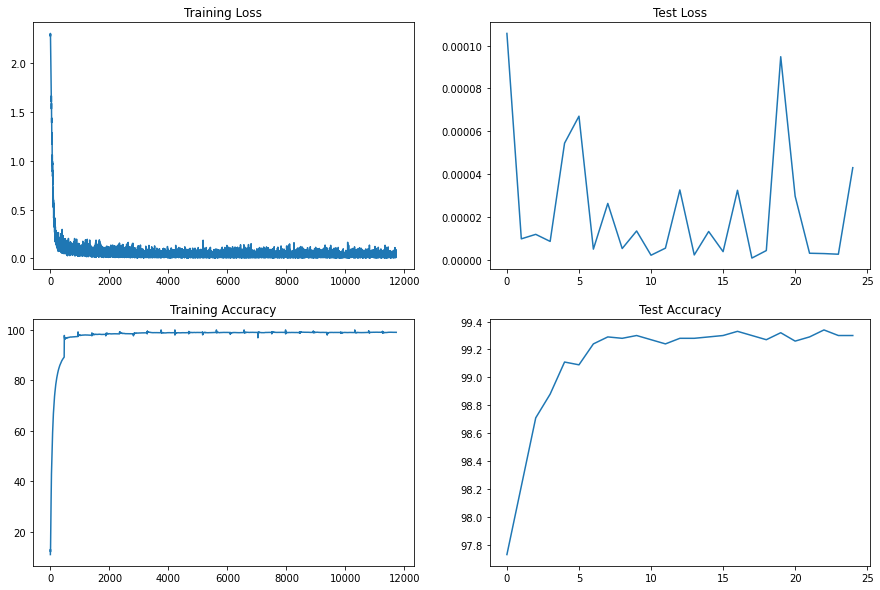

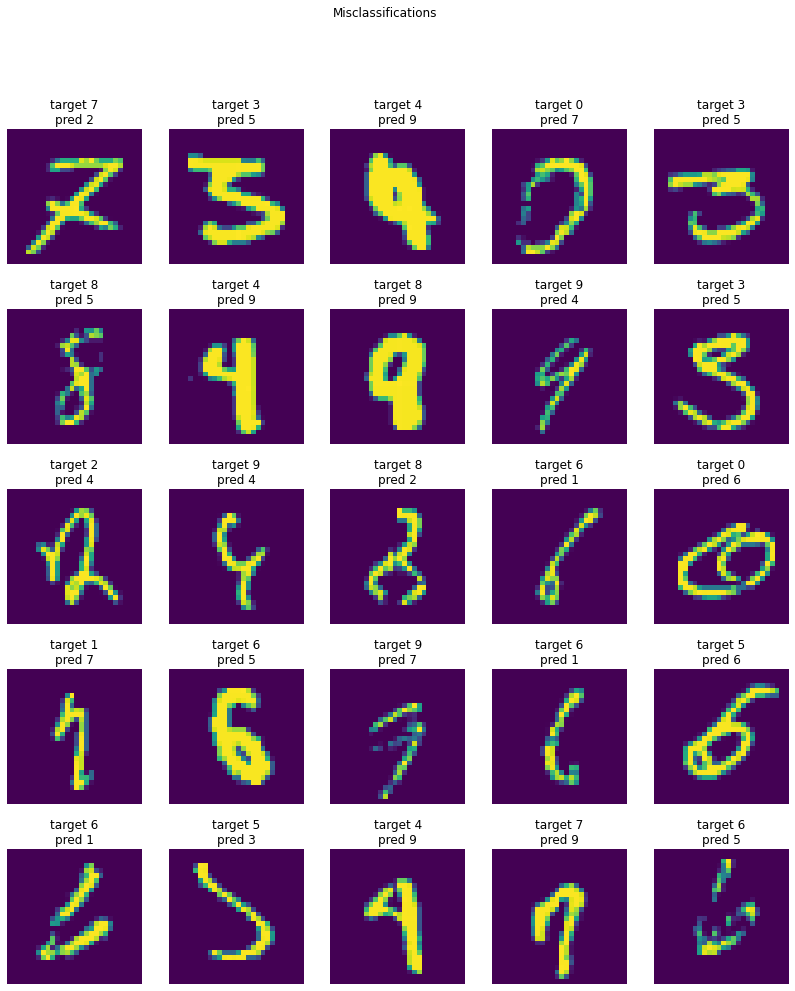

  0%|          | 0/469 [00:00<?, ?it/s]


-----------------------------------------------

-----------------------------------------------
GBN_L1_L2
EPOCH: 0 last LR= [0.01] LR =  [0.01]


Loss=0.3400566577911377 Batch_size=468 Accuracy=87.76: 100%|██████████| 469/469 [00:18<00:00, 25.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Acccuracy= 9726/10000 (97.26%)

EPOCH: 1 last LR= [0.01] LR =  [0.01]


Loss=0.2537897229194641 Batch_size=468 Accuracy=97.37: 100%|██████████| 469/469 [00:18<00:00, 25.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9804/10000 (98.04%)

EPOCH: 2 last LR= [0.01] LR =  [0.01]


Loss=0.21308383345603943 Batch_size=468 Accuracy=97.56: 100%|██████████| 469/469 [00:17<00:00, 26.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Acccuracy= 9748/10000 (97.48%)

EPOCH: 3 last LR= [0.01] LR =  [0.01]


Loss=0.22130876779556274 Batch_size=468 Accuracy=97.57: 100%|██████████| 469/469 [00:18<00:00, 25.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9793/10000 (97.93%)

EPOCH: 4 last LR= [0.01] LR =  [0.01]


Loss=0.21409517526626587 Batch_size=468 Accuracy=97.73: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Acccuracy= 9834/10000 (98.34%)

EPOCH: 5 last LR= [0.01] LR =  [0.01]


Loss=0.23691311478614807 Batch_size=468 Accuracy=97.59: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Acccuracy= 9653/10000 (96.53%)

EPOCH: 6 last LR= [0.001] LR =  [0.0001]


Loss=0.15183401107788086 Batch_size=468 Accuracy=98.44: 100%|██████████| 469/469 [00:18<00:00, 25.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9914/10000 (99.14%)

EPOCH: 7 last LR= [0.001] LR =  [0.001]


Loss=0.14373557269573212 Batch_size=468 Accuracy=98.61: 100%|██████████| 469/469 [00:18<00:00, 25.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Acccuracy= 9920/10000 (99.20%)

EPOCH: 8 last LR= [0.001] LR =  [0.001]


Loss=0.18927592039108276 Batch_size=468 Accuracy=98.62: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Acccuracy= 9908/10000 (99.08%)

EPOCH: 9 last LR= [0.001] LR =  [0.001]


Loss=0.2070118933916092 Batch_size=468 Accuracy=98.66: 100%|██████████| 469/469 [00:18<00:00, 25.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9912/10000 (99.12%)

EPOCH: 10 last LR= [0.001] LR =  [0.001]


Loss=0.20380523800849915 Batch_size=468 Accuracy=98.66: 100%|██████████| 469/469 [00:18<00:00, 25.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9910/10000 (99.10%)

EPOCH: 11 last LR= [0.001] LR =  [0.001]


Loss=0.15641680359840393 Batch_size=468 Accuracy=98.64: 100%|██████████| 469/469 [00:18<00:00, 25.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9907/10000 (99.07%)

EPOCH: 12 last LR= [0.0001] LR =  [1e-05]


Loss=0.12528789043426514 Batch_size=468 Accuracy=98.73: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0002, Acccuracy= 9924/10000 (99.24%)

EPOCH: 13 last LR= [0.0001] LR =  [0.0001]


Loss=0.12817952036857605 Batch_size=468 Accuracy=98.89: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9921/10000 (99.21%)

EPOCH: 14 last LR= [0.0001] LR =  [0.0001]


Loss=0.13796275854110718 Batch_size=468 Accuracy=98.80: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Acccuracy= 9927/10000 (99.27%)

EPOCH: 15 last LR= [0.0001] LR =  [0.0001]


Loss=0.17721083760261536 Batch_size=468 Accuracy=98.81: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9922/10000 (99.22%)

EPOCH: 16 last LR= [0.0001] LR =  [0.0001]


Loss=0.14625246822834015 Batch_size=468 Accuracy=98.81: 100%|██████████| 469/469 [00:18<00:00, 25.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9926/10000 (99.26%)

EPOCH: 17 last LR= [0.0001] LR =  [0.0001]


Loss=0.19216182827949524 Batch_size=468 Accuracy=98.83: 100%|██████████| 469/469 [00:18<00:00, 25.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9924/10000 (99.24%)

EPOCH: 18 last LR= [1e-05] LR =  [1.0000000000000002e-06]


Loss=0.15532661974430084 Batch_size=468 Accuracy=98.86: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9927/10000 (99.27%)

EPOCH: 19 last LR= [1e-05] LR =  [1e-05]


Loss=0.20121893286705017 Batch_size=468 Accuracy=98.82: 100%|██████████| 469/469 [00:18<00:00, 25.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9922/10000 (99.22%)

EPOCH: 20 last LR= [1e-05] LR =  [1e-05]


Loss=0.12991365790367126 Batch_size=468 Accuracy=98.89: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9926/10000 (99.26%)

EPOCH: 21 last LR= [1e-05] LR =  [1e-05]


Loss=0.1407056599855423 Batch_size=468 Accuracy=98.91: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9926/10000 (99.26%)

EPOCH: 22 last LR= [1e-05] LR =  [1e-05]


Loss=0.14367130398750305 Batch_size=468 Accuracy=98.90: 100%|██████████| 469/469 [00:18<00:00, 25.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9921/10000 (99.21%)

EPOCH: 23 last LR= [1e-05] LR =  [1e-05]


Loss=0.21552099287509918 Batch_size=468 Accuracy=98.83: 100%|██████████| 469/469 [00:18<00:00, 25.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9923/10000 (99.23%)

EPOCH: 24 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-07]


Loss=0.16339194774627686 Batch_size=468 Accuracy=98.83: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]



Test set: Average loss: 0.0002, Acccuracy= 9925/10000 (99.25%)

Total Misclassifications : 75


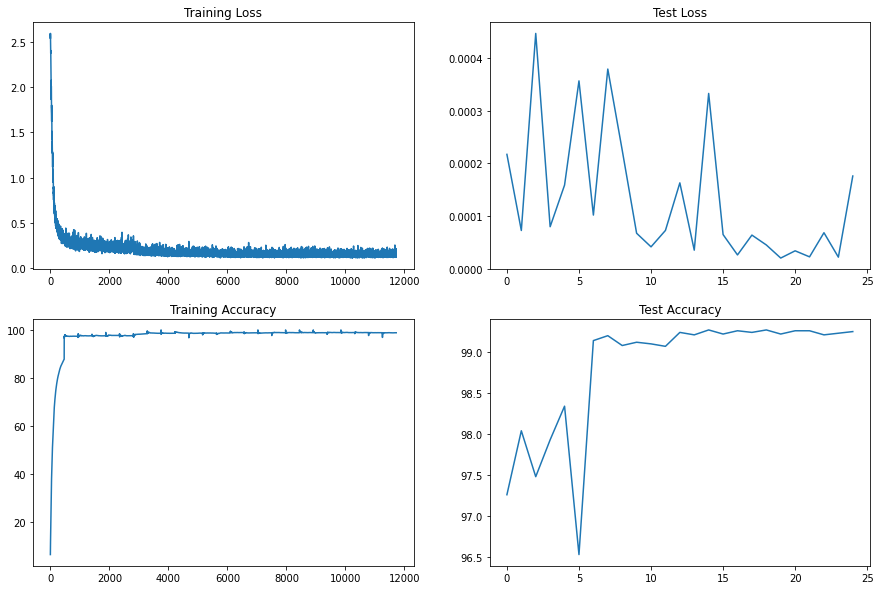

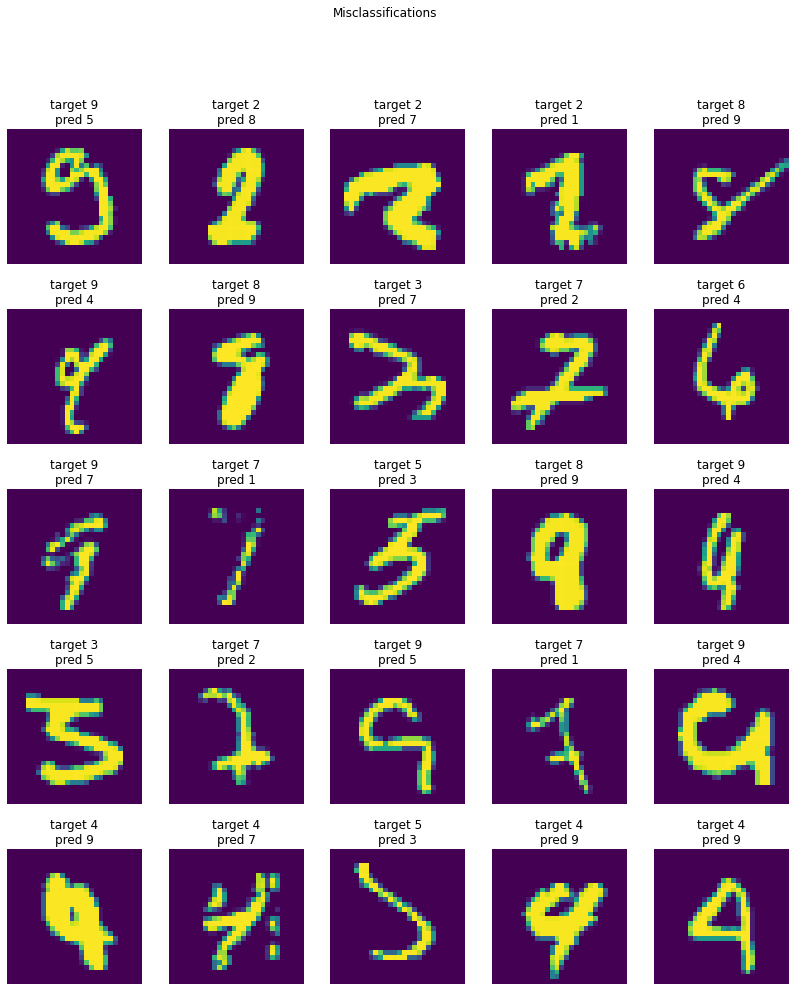

In [15]:
trail_iterations = [('BN_L1', model_bn, 5e-3, 0), ('BN_L2', model_bn, 0, 5e-4), ('bn_L1_L2', model_bn,5e-3, 5e-4) , 
                    ('GBN', model_gbn,0,0), ('GBN_L1_L2', model_gbn, 5e-3, 5e-4)]
      
metric_acc_values = []
metric_loss_values = []

for iteration, trail in enumerate(trail_iterations):
  print("\n-----------------------------------------------")
  print("\n-----------------------------------------------")
  print(trail[0])
  EPOCHS = 25
  if iteration in (0,1,2):
    myModel = Net().to(device)
  else:
    myModel = NetWithGBN().to(device)
  optimizer = optim.SGD(myModel.parameters(), lr=0.01, momentum=0.9, weight_decay=trail[2])
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

  trainer = Trainer()

  for epoch in range(EPOCHS):
      print("EPOCH:", epoch, "last LR=",scheduler.get_last_lr(), "LR = ", scheduler.get_lr())
      
      trainer.train(myModel, device, train_loader, optimizer, epoch, trail[3])
      trainer.test(myModel, device, test_loader)
      scheduler.step() # for StepLR

  (train_losses, test_losses, train_acc, test_acc) = trainer.getValues()

  plot_metrics(train_losses, train_acc, test_losses, test_acc)
  metric_acc_values.extend([test_acc])
  metric_loss_values.extend([test_losses])

  misclassifications = trainer.get_misclassified(myModel, test_loader, device)
  plot_misclassification(misclassified=misclassifications) 


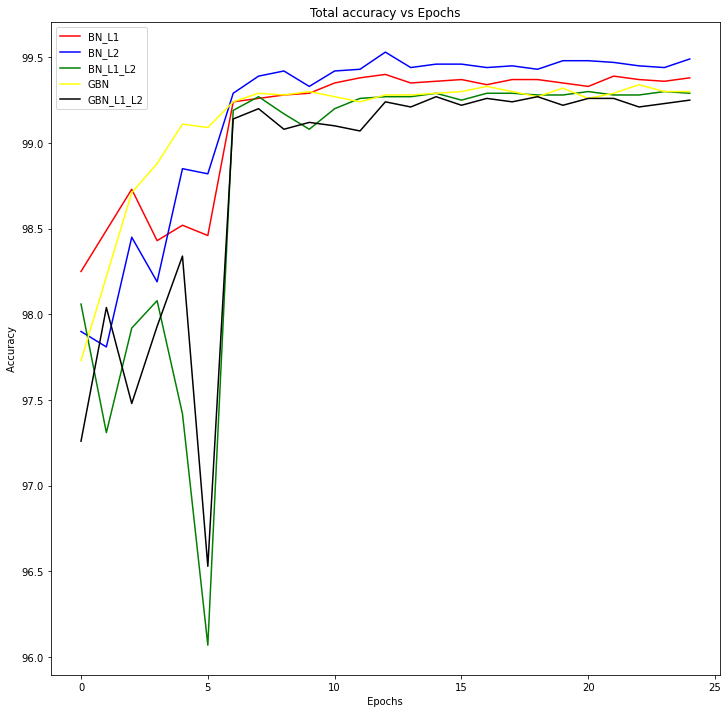

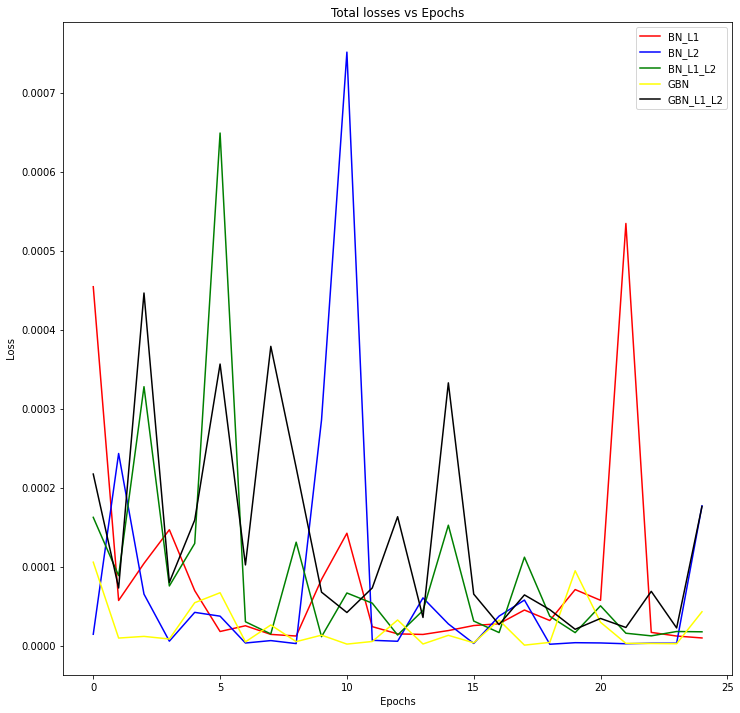

In [16]:
def plot_acc_loss(acc_loss, msg):
    plt.figure(figsize=(12,12))
    plt.plot(acc_loss[0],color='Red',   label='BN_L1')
    plt.plot(acc_loss[1],color='Blue',     label='BN_L2')
    plt.plot(acc_loss[2],color='Green',    label='BN_L1_L2')
    plt.plot(acc_loss[3],color='Yellow',  label='GBN')
    plt.plot(acc_loss[4],color='Black', label='GBN_L1_L2')
        
    plt.xlabel(' Epochs ')

    if msg == 'Loss':
        plt.ylabel(' Loss ')
        plt.title('Total losses vs Epochs')
    elif msg == 'Acc':
        plt.ylabel(' Accuracy ')
        plt.title('Total accuracy vs Epochs')

    plt.legend(loc = 'upper left' , bbox_to_anchor = (1,1))
    plt.legend()
    
    plt.show()


plot_acc_loss(metric_acc_values, "Acc")

plot_acc_loss(metric_loss_values, "Loss")